In [84]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import re
import datetime

from pathlib import Path
from ast import literal_eval

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Cases of Failure for the Old Parsing Tool

## Case1: Number of Items Exceeds 13

## Case2: Total Prices Matches TotalPaid Instead

## Case3: SubTotal = TotalPaid = 0

## Case4: Cash X2 (or Cash + Credit Card) in the Digital Receipt

2 rows of 'Cash' after items in the digital receipt, screwing up the parsing. Specifically, the amount of the second 'Cash' was recorded as 'SubTotal'. Alternatively, Cash followed by two rows of credit card (card number + card type/amount).

Note: Sometimes one of the transaction values would be negative!!

## Case5: Items with Negative Prices not Recorded Properly (Open \$)

CHK 128                    GST 0
1230 Del Real                171
TRN 171/607     MAR11'14  2:06PM
GCIS Cafe  

================================

Main                            
1 Misc                 2.79     
1 Cookie               1.69     
Open $               0.69-      
XXXXXXXXXXXX5756    XX/XX       
MasterCard           4.15       
Subtotal             3.79       
Tax                  0.36       
Total Paid       4.15       

================================

## Case6: 'Meal Plan' Counted as an Item ('Meal Plan' -> Transaction Type)

77		1/31/14 12:33	1	0		Property	Beatrice Del Real
							
		1/31/16 12:33	1	Misc	1.69	GCIS Cafe	Beatrice Del Real
		1/31/16 12:33	1	BOAR MTO Deli	6.49	GCIS Cafe	Beatrice Del Real
		1/31/16 12:33	1	Apple Fritter	1.69	GCIS Cafe	Beatrice Del Real
		1/31/16 12:33	1	Meal Exchange		GCIS Cafe	Beatrice Del Real
		1/31/16 12:33		Meal Plan	9.87	GCIS Cafe	Beatrice Del Real
		1/31/16 12:33		Trans: 19362324		GCIS Cafe	Beatrice Del Real
		1/31/16 12:33		Meal Plan #: 101		GCIS Cafe	Beatrice Del Real
		1/31/16 12:33		Code: 00		GCIS Cafe	Beatrice Del Real
							
				Sub Total	9.87		
				Tax	0		
				Service Charge	0		
				Check Total	9.87		

## Case 7: SVC Transactions

CHK 579                    GST 0
1245 Guirdo                  151
TRN 151/43221   FEB27'15  2:15PM
Stuart Cafe                     

================================

Main                            
1 vitaminwater zer     2.89     
Trans:28577404               
Bal:  $0.00 Low                 
SVC Plan #: 502                 
SVC                  3.05       
Trans: 28577449                 
Bal:  $49.89                    
SVC Plan #: 502                 
SVC                  0.11       
Subtotal             2.89       
Tax                  0.27       
Total Paid       3.16           

================================

## Case 8: "Change Due" stored as "Total Paid"

CHK 321                    GST 0
1263 Carmona                 142
TRN 13/6953     OCT31'14 10:01AM
Law Sch Cafe                    

================================

Main                            
1 Misc                 1.99     
Cash              5285.18       
Subtotal             1.99       
Tax                  0.19       
Total Paid       2.18           
Change Due        5283.00       

================================

## Case 9: Number of Misc Items Not Reflected Propoerly in Scraped Data

CHK 531                    GST 0
1263 Carmona                 142
TRN 13/16340    DEC09'14  3:24PM
Law Sch Cafe                    

================================

Main                            
199 Misc               199.00   
269 Misc                53.80   
EXEMPTION            0.00  X    
XXXXXXXXXXXX7900    XX/XX       
MasterCard         252.80  X    
Subtotal           252.80       
Total Paid   252.80           

================================

## Case 10: Transactions with "Exemption"

CHK 503                    GST 0
1233 Andres                  191
TRN 191/17435   FEB27'14  9:06AM
Harris  Cafe                    

===================================

Main                            
1 Bagel w Cream Ch     2.19     
1 Bagel w Cream Ch     2.19     
1 Jumbo Muffin         2.29     
1 Jumbo Muffin         2.29     
1 Fresh Fruit          1.09     
1 Fresh Fruit          1.09     
1 Fresh Fruit          1.09     
EXEMPTION            0.00  X    
XXXXXXXXXXXX3588    XX/XX       
MasterCard          12.23  X    
Subtotal            12.23       
Total Paid     12.23            

==================================

# Building an Item Name Dictionary to Clean Up Item Names

In [2]:
#load the calorie lookup database
lookup_df = pd.read_csv('CafeFiles_For_Sharing/CaloriesLookup/AllCafes.csv',header=0)
lookup_df = lookup_df.replace(np.nan, '', regex=True)
lookup_df.head()

,CafeName,#,Item #,Item Name,Calories,Calories.1,Scanner Item,Accuracy,Price,Category,Description,Comments
0,Gordon,275,100003,Misc,254.96,,,1,,,,
1,Harris,275,100003,Misc,254.96,,,1,,,,
2,Law,275,100003,Misc,254.96,,,1,,,,
3,Stuart,275,100003,Misc,254.96,,,1,,,,
4,Gordon,278,100058,SteamedMilkG,150.00,,,1,,,,


In [3]:
#all the unique item names in the lookup database
db_item_names = lookup_df['Item Name'].unique()

In [4]:
#manually built dictionary
#keys (left) in the dictionary are the item names used in the checks
#values (right) are the item names in the calorie-lookup database

item_dict = {'SPRITE 20 OZ':'z SPRITE 20',
             'SPRITE ZERO 20 O':'z SPRITE ZERO 20',
             'Fountain Sm':'Fountain   Sm',
             'Foutain Med':'Fountain  Med',
             'KELL SPECIAL K C':'z KELL SPCL K C',
             'Sunchips Harvest':'z Sunchips Hrvst',
             'Tuna Salad':'z Tuna Salad',
             'NJ BLUE MACHINE':'z NJ BLUE MCHN',
             'NJ BERRY BLAST':'z NJ BERRY BLAST',
             'TROPICANA APPLE':'z TRP APPLE',
             'KELL POP SS F/CI':'z KELL PP SSF/CI',
             'Oikos Straw Frui':'z OikosStrawFrui',
             'Sunchips Orig':'z Sunchips Orig',
             'COKE CLASSIC 20':'z COKE CLSSIC 20',
             'Dr.Pepper 20oz':'z Dr. Pepper 20',
             'Dr.PepprDiet 20':'z Dr.PeppDiet 20',
             'PEPSI 20 OZ':'z PEPSI 20',
             'DIET PEPSI 20 OZ':'z DIET PEPSI 20',
             'Cke Cher Zero 20':'z Cke Cher Z 20',
             'DIET MT DEW 20 O':'z DIET MT DEW 20',
             'Red Bull 8.3 Oz':'z RedBull 8.3Oz',
             'SNAPP TEA RAS':'z SNPLE TEA RAS',
             'SNAPPLE PEACH TE':'z SNPLE PEACH TE',
             'STRBCKS FRAP VAN':'z STRBCKS FRPVAN',
             'Cappuccino Lg':'Coffee Lg',
             'AQUAFINA 1LT':'z AQUAFINA  1LT',
             'AQUAFINA 20oz':'z AQUAFINA 20oz',
             'Kellgs Rce Kr Ce':'z Kell Rce Kr Ce',
             'NJ MIGHTY MANGO':'z NJ MITY MANGO',
             'Baked Chd Sr CR':'z Baked ChdSr CR',
             'Bareman Whole 16':'z Bareman Whl 16',
             'Ms V Smokehouse':'z MsV Smokehouse',
             'TROPICANA APPLE':'z TRP APPLE',
             'TROPICANA CRANBE':'z TRP CRANBE',
             'TROPICANA GRAPE':'z TRP GRAPE',
             'VIT WATER ENERGY':'z VIT WTR ENERGY',
             'VIT WATER XXX':'z VIT WTR XXX',
             'TROPICANA NO PUL':'z TRP NO PUL',
             'TROPICANA SOME P':'z TRP SOME P',
             'NJ POWER C':'z NJ POWER C',
             'STRBCKS FRAP COF':'z STRBCKS FRPCOF',
             'Ms V Simply Sea':'z MsV SimplySea',
             'Baked SC Onion':'z Baked SC Onion',
             'Cafe Mocha Sm':'Coffee Sm',
             "REESE'S REG SZ":"z REESE'S REG SZ",
             'KELL NG BLUEBERR':'z KELL NG BLUBRY',
             'TWIX REG SZ':'z TWIX REG SZ',
             'AQUAFINA 20oz':'z AQUAFINA 20oz',
             'SNAPPLE DIET LEM':'z SNPLE DIET LEM',
             'SNAPPLE DIET PEA':'z SNPLE DIET PEA',
             'SNAPPLE LEMO TEA':'z SNPLE LEMO TEA',
             'Doritos Cool Ran':'z Doritos CRnch',
             'Sunships Garden':'z Sunships Grdn',
             'FROSTED MINI WHE':'z FRSTD MINI WHE',
             'Bareman Whole 16':'z Bareman Whl 16',
             'STRBCKS FRAP MOC':'z STRBCKS FRPMOC',
             'FR Mozzarlla Sal':'z FR Mzzrlla Sld',
             'Oikos Blueberry':'z OikosBlueberry',
             'Ruffles Orig':'z Ruffles Orig',
             'Sf Red Bull':'z Sf RedBull',
             'Chick Caesar Wap':'z Chck Csar Wrap',
             'ChefSalad':'z Chef Salad',
             'CobbSalad':'z ChcknCobbSalad',
             'Bareman Choc 16o':'z Bareman Choc16',
             'DIET COKE 20 oz':'z DIET COKE 20',
             'Bareman 2% 16':'z Bareman 2%  16',
             'Dr.PepprDiet 20':'z Dr.PeppDiet 20',
             'KELL NG STRAWBER':'z KELL NG STRBRY',
             'SNICKERS REG SZ':'z SNICKERS RG SZ',
             'Fountain Sm':'Fountain   Sm',
             'Lays Classic 1.5':'z Lays Clssc 1.5',
             'FruitCup $3.59':'z FruitCup $3.59',
             'M&M REG SZ':'z M&M REG SZ',
             'DIET COKE LIME 2':'z DIET COKE LM 2',
             'HummusWrap':'z HummusWrap',
             'Baked Chd Sr CR':'z Baked ChdSr CR',
             'M&M PEANUT REG S':'z M&M PNUT REG S',
             'SNAPPLE DIET RAS':'z SNPLE DIET RAS',
             'Oikos Vanilla':'z Oikos Vanilla',
             'Cafe Latte Lg':'Cafe Latte LG',
             'KELL POP TART SS':'z KELL PP TARTSS',
             'KELL NG STRAWBER':'z KELL NG STRBRY',
             'Cappuccino Sm':'Coffee Sm',
             'Lays BBQ 1.5oz':'z Lays BBQ 1.5oz',
             'Ms V Salt Ving':'z MsV Salt Ving',
             'SNAPPLE PEACH TE':'z SNPLE PEACH TE',
             'Cafe Latte Sm':'Coffee Sm',
             'GATR FR PCH 20oz':'z GATR FRPCH 20',
             'MS V Jalapeno':'z MsV Jalapeno',
             'COKE ZERO 20 OZ':'z COKE ZERO 20',
             'NJ SFOOD GRN MAC':'z NJ SFD GRN MAC',
             'NJ STRAW/BAN C':'z NJ STRW/BAN C',
             'CLIF BAR OG BLUB':'z CLIFBAR OG BLU',
             'MT DEW 20 OZ':'z MT DEW 20',
             'Baked Lay Orig':'z Baked Lay Orig',
             'Kellgs Corn Flks':'z Kell Corn Flks',
             'KELL POP SS F/ST':'z KELL PP SSF/ST',
             'NJ PROTEIN ZONE':'z NJ PRTN ZONE',
             'Bareman Choc 16o':'z Bareman Choc16',
             'Kellgs Smrt Strt':'z Kell Smrt Strt',
             'KELL FROSTED FLA':'z KELL FRSTD FLA',
             'KELL NG APPLE':'z KELL NG APPLE',
             'Cafe Americ Sm':'Coffee Sm',
             'Ruffles Chd Sour':'z RufflesChdSour',
             'Cookie':'Choc Chip Cookie',
             'Danish':'Cheese Danish',
             'YogurtParf':'z Yogurt Parfait',
             'RAISIN BRAN CRUN':'z RASIN BRN CRUN',
             'Stacy Simply Nak':'z Stacy SmplyNak',
             'Asian Noodle Sal':'z Asian Ndle Sld',
             'ChickPenne Pesto':'z ChckPen Pesto',
             'Turk Whole Wheat':'z Turk Whole Wht',
             'SmTurkMarb':'z SmTurkMarb',
             'Vegan BBQ Slaw S':'z Vegn BBQSlaw S',
             'Vit water Focus':'z VIT water Foc',
             'Stacy Parmesan':'z Stacy Parmesan',
             'Doritos Nacho Ch':'z Doritos NchoCh',
             'ChickSal/Prezel':'z ChckSal/Prezel',
             'Fr&ChPlate':'z Fruit Ch Plate',
             'Stacys Cinn Sgr':'z Stacys CinnSgr',
             'Tomato-MozzBollo':'z Tmto-MozzBollo',
             'VegCup':'z Veggie Cup',
             'Veggie Cup':'z Veggie Cup',
             'Turk-ChedSour':'z Turk-ChedSour',
             'LUNA BAR BLUE BL':'z LUNABAR BLU BL',
             'VIT WATER REVIVE':'z VIT WTR REVIVE',
             'TROPICANA CALCIU':'z TRP CALCIU',
             'Cafe Wh Mocha Sm':'Coffee Sm',
             'SNAPPLE MANGO MA':'z SNPLE MANGO MA',
             'LPTN Purel UNSWE':'z LPTN PureUnswt',
             'LPTN Nat Dt Gr T':'z LPTN Nat DtGrT',
             'VANILLA COKE 20':'z VNLLA COKE 20',
             'Reg MTO 4.99':'Reg MTO 5.49',#the price in name doesn't match, but the same item
             'Car Mach Sm':'Coffee Sm',
             'VIT WATER POWER-':'z VIT WTR POWER-',
             'ItalnBeef-Clsc':'Italian Beef',
             'SNAPPLE APPLE':'z SNPLE APPLE',
             'SNAPPLE STR KIWI':'z SNPLE STR KIWI',
             'Falafel Sndwch':'Falafel',
             'Organic Oatmeal':'Oatmeal',
             'Ham Swiss Sourdo':'z Ham Swiss Srdo',
             'z LPTN PURE LMN':'z LPTN  PURE LMN',
             'SNAPPLE FRUIT PU':'z SNPLE FRUIT PU',
             'LIPTON SWEET TEA':'z LPTN SWEET TEA',
             'LPTN GR TEA CIT':'z LPT DT GRN CTR',
             'LPT DT GRN CTRS':'z LPT DT GRN CTR',
             'Steamer Sm':'Steamer  Sm',
             'VIT WATER ESSENT':'z VIT WTR ESSENT',
             'Baked BBQ Lays':'z Baked BBQ Lays',
             'Pretz Tiny Twist':'z PretzTinyTwist',
             'Canada Dry 20oz':'z Canada Dry 20',
             'Yogurt Parfait':'z Yogurt Parfait',
             'PFMilk Choc':'z PFMilk Choc',
             'Eye Opener Sm':'Fuze Iced Tea Lg',#130559
             'Eye Opener Med':'Ice Chai Lat Med',#130560
             'Eye Opener Lg':'Ice Chai Latt Lg',#130561
             'Bareman Slim 16':'z Bareman Skim16',
             'Argo Green Ginge':'z Argo Grn Ginge',
             'Vitwater Focus':'z VIT water Foc',
             'PFMilk 2perc':'z PFMilk 2perc',
             'Argo CharitaTea':'z Argo ChariTea',
             'LUNA BAR OG CHOC':'z LUNABAR OG CHC',
             'z GATR ORANGE 20':'Gatr Orange',
             'GATR ORANGE 20oz':"Gatr Orange",
             'Argo Carlina Hon':'z ArgoCarlinaHon',
             'Argo Mojitea':'z Argo Mojitea',
             'Chickceasarsalad':'z ChckCsrSld',
             'Argo Pomegranate':'z Argo Pom',
             'FruitCup $3.49':'z FruitCup $3.59', #????
             'FruitCup3.49':'z FruitCup $3.59',#????
             'Argo White Tea A':'z Argo WhiteTeaA',
             'Chef Salad':'z Chef Salad',
             'ChickenCobbSalad':'z ChcknCobbSalad',
             'WRIGLEY 5 REACT':'z WRIG 5 REACT',
             'Wrap':'z Wrap',
             'Mayan Mocha Sm':'Coffee Sm',
             'CLIF BAR OG CHOC':'z CLIFBAR CH BRW',
             'Waffle Sausage':'Morning Wrap',
             'Waffle Egg':'Waffle Bar',
             'z Bareman 2% 16':'z Bareman Skim16',
             'Fountain Med':'Fountain  Med',
             'z Bareman Skim 16':'z Bareman Skim16',
             'Sushi-Misc':'Sushi - Misc',
             'Sushi-misc':'Sushi - Misc',
             'Bewley Hot tea':'Bewley Hot Tea',
             "Bewley's Hot Tea":'Bewley Hot Tea',
             'Fountain Sim':'Fountain   Sm',
             'GrabnGo Saffron':'GrabNGo-saffron',
             'Cappucino Sm':'Coffee Sm',
             'Coffee SM':'Coffee Sm',
             'Fountain SM':'Fountain   Sm',
             'BOAT MTO Deli':'BOAR MTO Deli',
             'Baked Lay Org':'z Baked Lay Orig',
             'Ms V Salt Ving':'z MsV Salt Ving',
             'WRIG ORBIT BUBBL':'z WRIG ORB BUBBL',
             'NJ RED MACHINE':'z NJ RED MACHINE',
             'Mayan Mocha Lg':'Mayan Hot Ch Lg',
             'Owl Mug':'Own Mug',
             'Free Coffee 0.00':'Free Coffee',
             'SNAPPLE DIET LM':'z SNPLE DIET LEM',
             'Caffe Latte Lg':'Cafe Latte LG',
             'Fruit & Ch Plate':'z Fruit Ch Plate',
             'LUNA Blubrry bls':'z LUNABAR BLU BL',
             'Bagle Sandwich':'Bagel Sandwich',
             'Fruit Cup 3.59':'z FruitCup $3.59',
             'Breakfast Cross':'Breakfast Crossa',
             'Breakfast Crosa':'Breakfast Crossa',
             'Baked Lay-Orig':'z Baked Lay Orig',
             'HONEST ADE Peach':'HONEST ADE PEACH',
             'Ms V Simply Tea':'z MsV SimplySea',
             'Café Mocha Md':'Cafe Mocha Med',
             'Sunchips Harverst':'z Sunchips Hrvst',
             'BOAR MTO DELI':'BOAR MTO Deli',
             'Café Mocha Sm':'Coffee Sm',
             'Cofffe Sm':'Coffee Sm',
             'Cofee Sm':'Coffee Sm',
             'Daily Coffee Sm':'Coffee Sm',
             'Daily Sm Soup':'Daily Soup Sm',
             'Free Cofee':'Free Coffee',
             'NJ ACAI MACHINE':'z NJ ACAI MCHN'}

In [5]:
def clean_item_names(item_name, item_dict):
    '''
    clean the item name to match the names in the lookup database
    '''
    if item_name in item_dict:
        return item_dict[item_name]
    else:
        return item_name

# New Parsing Program
## Objectives
1. Account for the cases above during parsing.
2. Improved format: store item names and prices in the form of numpy arrays instead of multiple texts/numbers.

Note: data came in 3 different formats (format 2 and 3 are similar; delete an empty column in format 3 to make it into format 2)

## Parsing functions for format 1 files

In [6]:
def parse_mega(mega_info):
    '''
    Parse the mega info of a check into
    CHK#, cafe, Date, Time, and cashier name.
    '''
    #set the default values for the data fields
    checknum = ''
    cafe = ''
    date = ''
    time = ''
    cashier = ''
    #split the mega information into multiple lines
    lines = mega_info.splitlines()
    for line in lines:
        l = (line.strip(" ")).split(" ")
        if l[0] == 'CHK':
            checknum = 'CHK' + l[1]
        elif l[-1][-2:] in ['AM','PM']:
            if l[-2] == '':
                date = l[-3]
            else:
                date = l[-2]
            time = l[-1]
        elif l[-1] == 'Cafe':
            cafe = l[0]
        else:
            cashier = ' '.join(l[:-1]).strip(' ')
    output = {'cafe':cafe, 'Check#':checknum, 'Date':date, 'Time':time, 'Cashier':cashier}
    return output


def parse_main(receipt, mega, item_names, item_dict):
    '''
    The function takes a single digital receipt and parse it into relevant data fields.
    
    ''' 
    #split a receipt into lines
    lines = receipt.splitlines()
    
    #create the item_counts vector
    item_vector = [0]*len(item_names)
    price_vector = [0]*len(item_names)
    
    #set default value for other data fields
    subtotal = 0
    tax = 0
    totalpaid = 0
    payment_method = ''
    credit_card_info = ''
    open_value = 0
    water_tax = 0
    re_check = False
    unmatched_items = ''
    qc_failed = False
    
    #process the text line by line
    for line in lines:
        line = line.strip(" ")
        w = line.split(" ")
        if len(w)>1:
            if w[0] == 'Subtotal':
                    if w[1][-1] == '-':
                        subtotal -= float(w[1][:-1])
                    else:
                        subtotal += float(w[1])
            elif (w[0] == 'Total')&(w[1] == 'Paid'):
                if w[2][-1] == '-':
                    totalpaid -= float(w[2][:-1])
                else:
                    totalpaid += float(w[2])
            elif w[0] in ['MasterCard','Visa','AMEX','Discover']:
                payment_method = 'Credit Card'
                credit_card_info = w[0] + credit_card_info
            elif w[0] == 'Cash':
                if not (w[1][-1] == '-')|(w[1][-1] == 'V'):
                    if float(w[1])>0:
                        payment_method = 'Cash'
            elif w[-1] == 'XX/XX':
                credit_card_info = w[0]
                payment_method = 'SVC Plan'
            elif w[0] == 'SVC' and w[1] == 'Offline':
                payment_method = 'SVC Offline'
            elif w[0] == 'SVC' and w[1] == 'Plan':
                credit_card_info = ' '.join(w)
            elif w[0] == 'Meal' and w[1] == 'Plan' and w[2]=='#:':
                payment_method = 'Meal Plan'
                credit_card_info = ' '.join(w)
            elif w[0] == 'Meal' and w[1] == 'Plan':
                pass
            elif w[0] == 'Open' and ((w[1]=='$')|(w[1]=='%')):
                open_value += -float(w[-1][:-1])
            elif w[0] == 'Water' and w[1]=='Tax':
                water_tax += float(w[-1])
            elif w[0] == 'Ext' and w[1]=='Cred':
                payment_method = 'Credit Card'
                credit_card_info = 'Ext Cred Card'
            elif w[0] in ['Bal:', 'Code:', 'Trans:', 'Service', 'Change', 'EXEMPTION']:
                pass
            elif w[1] == 'Meal' and w[2] == 'Exchange':
                pass
            elif w[0] == 'Meal' and w[1] == 'Ticket':
                payment_method = 'Meal Ticket'
            elif w[1] == 'No' and w[2] == 'Tax':
                pass
            elif " ".join(w) == mega['Cashier']:
                pass
            elif w[0] == 'CANCELLED':
                cancelled = True
            else:
                if w[-1] == 'R' and w[-2][-1] == '-':
                    re_check = True
                    temp_name = clean_item_names(" ".join(w[1:-2]), item_dict)
                else:
                    temp_name = clean_item_names(" ".join(w[1:-1]), item_dict)
                if temp_name in item_names:
                    item_index = list(item_names).index(temp_name)
                    item_cnt = int(w[0])
                    item_vector[item_index] += item_cnt
                    if re_check:
                        price = -float(w[-2][:-1])
                    else:
                        if w[-1] == 'V':
                            price = -float(w[-2])
                        elif w[-1][-1] == 'V':
                            price = -float(w[-1][:-2])
                        else:
                            price = float(w[-1])
                    price_vector[item_index] += price
                elif temp_name != '':
                    unmatched_items = unmatched_items + temp_name + ';'
    
    if abs(sum(price_vector) + open_value - subtotal)>=0.01:
        qc_failed = True
                    
    output = {'ItemVec':item_vector, 'PriceVec':price_vector,
              'SubTotal':subtotal, 'TotalPaid':totalpaid,
              'PaymentMethod':payment_method, 'CreditCardInfo':credit_card_info,
              'Open':open_value, 'WaterTax':water_tax,
              'Re':re_check, 'Unmatched':unmatched_items,
              'QCFailed':qc_failed}
    return output
    

def smart_parse(file, item_names, item_dict):
    '''
    The function takes a MS Excel file, the list of unique item names in the lookup database,
    and the item dictionary, and returns a pandas DataFrame object that contains the parsed data.
    '''
    
    output = []
    
    #open the Excel workbook
    wb = xlrd.open_workbook(file)
    
    #locate the sheet that has all the electronic receipts
    sheet = wb.sheet_by_index(len(wb.sheets())-1)
    
    #aggregate all the text in the target workbook
    aggr_text = ''
    for row_id in range(sheet.nrows):
        aggr_text += (str(sheet.cell_value(row_id,0))+"\n") 
    aggr_text = '================================'.join(aggr_text.split('================================')[:-1])
    
    #split the aggregated into individual checks
    checks = aggr_text.split("================================")
    
    #parse individual checks
    for check in checks:
        receipt = check.split('--------------------------------')
        #split the check into mega info and the body part
        mega_info = receipt[0]
        main_receipt = re.sub(' +', ' ',receipt[1])
        #collect the parsed data of the mega and the body parts
        output_mega = parse_mega(mega_info)
        output_main = parse_main(main_receipt, output_mega, item_names, item_dict)
        #output the parsed data if the check isn't empty (there are empty checks)
        if output_main:
            if output_mega['Check#']:
                output_main.update(output_mega)
                output.append(output_main)

    return output

In [7]:
#test the parsing function on a single file first

loc = "/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/0_Gordon/Data__Gordon_NOV12.xlsx" #change the file name

test_pd = pd.DataFrame(smart_parse(loc, db_item_names, item_dict))
test_pd[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,SubTotal,Time,TotalPaid,Unmatched,WaterTax,cafe
0,1230 Del Real,CHK298,MasterCardXXXXXXXXXXXX9997,NOV12'14,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[1.89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,4.39,8:02AM,4.81,,0,GCIS


In [8]:
#check if the test output contains any unmatched items or any observations that failed the QC tests
#if there is any unmatched item, please update the item dictionary
#if there is any observation that fails the QC test, update the parsing tool
test_pd[(test_pd['QCFailed']==True)&(test_pd['Unmatched']!=';')]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,SubTotal,Time,TotalPaid,Unmatched,WaterTax,cafe


In [9]:
def clean_credit_card(credit_card):
    """
    The function cleans up the credict card information
    """
    
    if credit_card == 'Mastercard':
        return 'MasterCard'
    elif credit_card == 'Vis a':
        return 'Visa'
    else:
        return credit_card.strip(" ")

def parsing2(file, item_names, item_dict):
    """
    Parsing function for a different format (format 2).
    Takes a xlsx file and returns a Pandas DataFrame object.
    """
    
    outputs = []
    
    #parse file
    wb = xlrd.open_workbook(file) #read xlsx workbook
    sheet = wb.sheet_by_index(0) #read sheet
    aggr_text = ''
    for row_id in range(sheet.nrows):
        if sheet.cell_value(row_id,0) and type(sheet.cell_value(row_id,0)) != str:
            if sheet.cell_value(row_id,1) not in ['Missing','N/A'] and sheet.cell_value(row_id,2) not in ['Missing','N/A']:
                #initiate output variables
                checknum = ''
                cafe = ''
                date = ''
                time = ''
                cashier = ''
                item_vector = [0]*len(item_names)
                price_vector = [0]*len(item_names)
                subtotal = 0
                tax = 0
                totalpaid = 0
                payment_method = 'Cash'
                credit_card_info = ''
                open_value = 0
                re_check = False
                unmatched_items = ''
                qc_failed = False
                water_tax = 0
                         
                checknum = 'CHK' + str(int(sheet.cell_value(row_id,0)))
                #print(checknum)
                if type(sheet.cell_value(row_id,2))==str:
                    date_n_time = sheet.cell_value(row_id,2).strip(" ")
                    date = date_n_time.split(" ")[0]
                    time = date_n_time.split(" ")[-1]
                else:
                    date_n_time = datetime.datetime(*xlrd.xldate_as_tuple(sheet.cell_value(row_id,2), wb.datemode)) #list
                    date = str(date_n_time.isoformat(' ', 'seconds')).split(" ")[0]
                    time = str(date_n_time.isoformat(' ', 'seconds')).split(" ")[-1]
                cafe += sheet.cell_value(row_id+2,6).strip(" ").split(" ")[0]
                cashier += sheet.cell_value(row_id,7)
                
                #find items
                for i in range(0,100):
                    temp_name = str(sheet.cell_value(row_id+i,4)).strip(" ")
                    if sheet.cell_value(row_id+i,3) and temp_name: #find items
                        item_name = clean_item_names(re.sub(' +', ' ',temp_name), item_dict)
                        if item_name in item_names: #if item matches
                            item_index = list(item_names).index(item_name)
                            item_cnt = int(sheet.cell_value(row_id+i,3))
                            item_vector[item_index] += item_cnt
                            if item_cnt < 0:
                                re_check = True
                            price = sheet.cell_value(row_id+i,5)
                            if price == '':
                                price = 0.0
                            price_vector[item_index] += price #assign price
                        elif item_name == 'Water Tax':
                            water_tax += sheet.cell_value(row_id+i,5)
                        else:
                            unmatched_items += item_name + ';'
                    elif temp_name and sheet.cell_value(row_id+i,2) and not sheet.cell_value(row_id+i,3):
                        if temp_name in ['MasterCard','Visa','AMEX','Discover',
                                         'Mastercard','Vis a',]:
                            payment_method = 'Credit Card'
                            credit_card_info = clean_credit_card(temp_name) + credit_card_info
                        elif temp_name[:2] == '**':
                            credit_card_info = credit_card_info + temp_name.split(" ")[0]
                        elif temp_name == 'Open $':
                            open_value += float(sheet.cell_value(row_id+i,5))
                    elif temp_name and not sheet.cell_value(row_id+i,2) and not sheet.cell_value(row_id+i,3):
                        if temp_name in ['Sub Total', 'Sub-total','Subtotal','Subtoal',
                                         'Sub total','sub total', 'subtotal', 'Subtotla',
                                         'Sub Total']:
                            subtotal += sheet.cell_value(row_id+i,5)
                        elif temp_name == 'Tax':
                            tax += sheet.cell_value(row_id+i,5)
                        elif temp_name in ['Check Total', 'Check total', 'Total Check',
                                           'Check  Total','Check Toal']:
                            if not sheet.cell_value(row_id+i,5) == '':
                                totalpaid += sheet.cell_value(row_id+i,5)
                            break
                
                #QC Check: fails if the individual prices do not sum up to the Subtotal
                if abs(sum(price_vector) + open_value - subtotal)>=0.01:
                    qc_failed = True
                    
                if unmatched_items == '0.0;':
                    unmatched_items = ''
                
                #format of the output DataFrame object
                output = {'cafe':cafe, 'Check#':checknum, 'Date':date, 'Time':time,
                          'ItemVec':item_vector, 'PriceVec':price_vector,
                          'SubTotal':subtotal, 'TotalPaid':totalpaid,
                          'PaymentMethod':payment_method, 'CreditCardInfo':credit_card_info,
                          'Open':open_value, 'Re':re_check, 'Unmatched':unmatched_items,
                          'QCFailed':qc_failed, 'Cashier':cashier, 'WaterTax':water_tax}
                
                outputs.append(output)
    
    return pd.DataFrame(outputs)

def parsing3(file, item_names, item_dict):
    """
    Parsing function for a different format (format 3).
    Takes a xlsx file and returns a Pandas DataFrame object.
    """
    
    outputs = []
    
    #parse file
    wb = xlrd.open_workbook(file) #read xlsx workbook
    sheet = wb.sheet_by_index(0) #read sheet
    aggr_text = ''
    for row_id in range(sheet.nrows):
        if sheet.cell_value(row_id,0) and type(sheet.cell_value(row_id,0)) != str:
            if sheet.cell_value(row_id,1) not in ['Missing','N/A'] and sheet.cell_value(row_id,2) not in ['Missing','N/A']:
                #initiate output variables
                checknum = ''
                cafe = ''
                date = ''
                time = ''
                cashier = ''
                item_vector = [0]*len(item_names)
                price_vector = [0]*len(item_names)
                subtotal = 0
                tax = 0
                totalpaid = 0
                payment_method = 'Cash'
                credit_card_info = ''
                open_value = 0
                re_check = False
                unmatched_items = ''
                qc_failed = False
                water_tax = 0
                         
                checknum = 'CHK' + str(int(sheet.cell_value(row_id,0)))
                #print(checknum)
                if type(sheet.cell_value(row_id,2))==str:
                    date_n_time = sheet.cell_value(row_id,2).strip(" ")
                    date = date_n_time.split(" ")[0]
                    time = date_n_time.split(" ")[-1]
                else:
                    date_n_time = datetime.datetime(*xlrd.xldate_as_tuple(sheet.cell_value(row_id,2), wb.datemode)) #list
                    date = str(date_n_time.isoformat(' ', 'seconds')).split(" ")[0]
                    time = str(date_n_time.isoformat(' ', 'seconds')).split(" ")[-1]
                cafe += sheet.cell_value(row_id+2,7).strip(" ").split(" ")[0]
                cashier += sheet.cell_value(row_id,9)
                
                #find items
                for i in range(0,100):
                    temp_name = str(sheet.cell_value(row_id+i,5)).strip(" ")
                    if sheet.cell_value(row_id+i,4) and temp_name: #find items
                        item_name = clean_item_names(re.sub(' +', ' ',temp_name), item_dict)
                        if item_name in item_names: #if item matches
                            item_index = list(item_names).index(item_name)
                            item_cnt = int(sheet.cell_value(row_id+i,4))
                            item_vector[item_index] += item_cnt
                            if item_cnt < 0:
                                re_check = True
                            price = sheet.cell_value(row_id+i,6)
                            if price == '':
                                price = 0.0
                            elif type(price) == str:
                                price = float(price.strip('`'))
                            price_vector[item_index] += price #assign price
                        elif item_name == 'Water Tax':
                            water_tax += sheet.cell_value(row_id+i,6)
                        else:
                            unmatched_items += item_name + ';'
                    elif temp_name and sheet.cell_value(row_id+i,2) and not sheet.cell_value(row_id+i,4):
                        if temp_name in ['MasterCard','Visa','AMEX','Discover',
                                         'Mastercard','Vis a',]:
                            payment_method = 'Credit Card'
                            credit_card_info = clean_credit_card(temp_name) + credit_card_info
                        elif temp_name[:2] == '**':
                            credit_card_info = credit_card_info + temp_name.split(" ")[0]
                        elif temp_name == 'Open $':
                            open_value += float(sheet.cell_value(row_id+i,5))
                    elif temp_name and not sheet.cell_value(row_id+i,2) and not sheet.cell_value(row_id+i,4):
                        if temp_name in ['Sub Total', 'Sub-total','Subtotal','Subtoal',
                                         'Sub total','sub total', 'subtotal', 'Subtotla',
                                         'Sub Total']:
                            subtotal += sheet.cell_value(row_id+i,6)
                        elif temp_name == 'Tax':
                            tax += sheet.cell_value(row_id+i,6)
                        elif temp_name in ['Check Total', 'Check total', 'Total Check',
                                           'Check  Total','Check Toal', 'Total']:
                            if not sheet.cell_value(row_id+i,6) == '':
                                totalpaid += sheet.cell_value(row_id+i,6)
                            break
                
                #QC Check: fails if the individual prices do not sum up to the Subtotal
                if abs(sum(price_vector) + open_value - subtotal)>=0.01:
                    qc_failed = True
                    
                if unmatched_items == '0.0;':
                    unmatched_items = ''
                
                #format of the output DataFrame object
                output = {'cafe':cafe, 'Check#':checknum, 'Date':date, 'Time':time,
                          'ItemVec':item_vector, 'PriceVec':price_vector,
                          'SubTotal':subtotal, 'TotalPaid':totalpaid,
                          'PaymentMethod':payment_method, 'CreditCardInfo':credit_card_info,
                          'Open':open_value, 'Re':re_check, 'Unmatched':unmatched_items,
                          'QCFailed':qc_failed, 'Cashier':cashier, 'WaterTax':water_tax}
                
                outputs.append(output)
    
    return pd.DataFrame(outputs)

In [61]:
#parse all files in a directory

test_dirs = ['/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/0_Gordon',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/1_Stuart',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/2_Harris',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/3_Law',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/4_missing txndtls allcafes/Gordon_Missing_2014',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/4_missing txndtls allcafes/Haris_Missing_2014',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/4_missing txndtls allcafes/Law_Missing_2014_NOTDWNLD',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2014-daylevel/4_missing txndtls allcafes/Stuart_Missing_2014',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/0_Gordon DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/1_Stuart DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/2_Harris DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/3_Law DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/4_missing txndtls allcafes done/Gordon DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/4_missing txndtls allcafes done/HarrisOld DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/4_missing txndtls allcafes done/Law DONE',
             '/Users/lingdai/Downloads/CafeFiles_For_Sharing (1)/2015-daylevel/4_missing txndtls allcafes done/Stuart DONE'] #change the path/directory

output_dfs = []

def parse_all_files(directory, item_names, item_dict):
    '''
    The function parses all the MS Excel files in a directory (folder) and
    returns the parsed data in a pandas DataFrame.
    
    inputs: directory
            item_names (unique item names in the lookup databaset)
            item_dict (item dictionary)
    output: aggr_df (pandas DataFrame object, with all the aggregated parsed data)
    '''
    file_list = []
    dfs = []
    pathlist = Path(directory).glob('*.xlsx')
    
    #get all the file names in the target directory
    for path in pathlist:
        file_list.append(str(path))
        
    #parse each individual MS Excel files and store the parsed data in separate pandas DataFrames
    for filename in file_list:
        try:
            try:
                try:
                    df = pd.DataFrame(smart_parse(filename, item_names, item_dict))
                    df['filename'] = filename
                    dfs.append(df)
                except:
                    df = pd.DataFrame(parsing2(filename, item_names, item_dict))
                    df['filename'] = filename
                    dfs.append(df)          
            except:
                df = pd.DataFrame(parsing3(filename, item_names, item_dict))
                df['filename'] = filename
                dfs.append(df) 
        except:
            print(filename)
        
    #aggregate all the pandas DataFrames into one
    if dfs != []:
        aggr_df = pd.concat(dfs,ignore_index=True)
        return aggr_df
    else:
        return None

for test_dir in test_dirs:
    if parse_all_files(test_dir, db_item_names, item_dict) is not None:
        output_dfs.append(parse_all_files(test_dir, db_item_names, item_dict))

aggr_df = pd.concat(output_dfs)

In [62]:
len(aggr_df)

138229

In [85]:
aggr_df['TotalPrice']=aggr_df['PriceVec'].apply(sum)
aggr_df[abs(aggr_df['TotalPrice']-aggr_df['SubTotal']+aggr_df['Open'])>0.1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
40,GRNC 8 ARA MGR,CHK573,MasterCard************2773,1/6/2015,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,1.10,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,0.00,2015-01-06,2015-01-06_GCIS_CHK573_1.0,0,False
81,GRNC 8 ARA MGR,CHK615,Visa************1704,1/6/2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[1.49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,10.37,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,9.07,2015-01-06,2015-01-06_GCIS_CHK615_9.47,3,True
120,GRNC 8 ARA MGR,CHK654,,1/6/2015,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Cash,"[7.67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,8.07,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,7.67,2015-01-06,2015-01-06_GCIS_CHK654_7.37,3,True
131,GRNC 8 ARA MGR,CHK665,MasterCard************7085,1/6/2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[1.89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,71.66,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,55.76,2015-01-06,2015-01-06_GCIS_CHK665_65.44,12,True
154,GRNC 8 ARA MGR,CHK687,,1/6/2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Cash,"[5.19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,7.61,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,6.19,2015-01-06,2015-01-06_GCIS_CHK687_6.95,2,True
197,GRNC 8 ARA,CHK731,Visa************9504,1/6/2015,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[11.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,...,13.07,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,11.48,2015-01-06,2015-01-06_GCIS_CHK731_11.94,2,True
238,GRNC 8 ARA MGR,CHK773,Visa************5760,1/6/2015,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[7.58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,8.69,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,7.58,2015-01-06,2015-01-06_GCIS_CHK773_7.94,2,True
667,GRNC 8 ARA MGR,CHK914,,1/7/2015,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Cash,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,10.16,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,8.78,2015-01-07,2015-01-07_GCIS_CHK914_9.28,2,False
710,GRNC 8 ARA MGR,CHK957,Discover************9919,1/7/2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[1.99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,5.88,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,5.27,2015-01-07,2015-01-07_GCIS_CHK957_5.37,3,True
771,GRNC 8 ARA MGR,CHK18,Visa************4546,1/7/2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[1.09, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,...,15.41,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,20.56,2015-01-07,2015-01-07_GCIS_CHK18_14.07,4,True


In [86]:
#store the data in pkl format so that ItemVec and PriceVec will stay as vectors instead of strings
aggr_df.to_pickle('aggr_check_data_raw.pkl') #change filename

In [87]:
aggr_df[aggr_df['Unmatched']!='']

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
4600,1230 Del Real,CHK892,,OCT09'14,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Cash,"[6.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,8.80,Primo Espresso;,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,8.04,2014-10-09,2014-10-09_GCIS_CHK892_8.04,2,True
4891,1230 Del Real,CHK21,,NOV04'14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Cash,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,3.06,Primo Espresso;,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,2.79,2014-11-04,2014-11-04_GCIS_CHK21_2.79,1,False


## Unmatched Items

Eye Opener Sm 2.29

Eye Opener Med

Eye Opener Lg

According to STU_FEB25, Eye Opener = 130559/130160/130561

In [88]:
#clean up the format of time

def convert_time(time_str):
    """
    This function converts a time string from AM/PM
    to 24-hour format (for consistency and for the purpose of analysis)
    """
    if time_str == '12:00PM' or time_str == '12:00pm':
        time_str = '12:00:00'
    elif time_str[-2:] in ['AM','am']:
        time_str = time_str[:-2]+':00'
    elif time_str[-2:] in ['PM','pm']:
        time_str = time_str[:-2]
        hour = int(time_str.split(":")[0])
        if hour != 12:
            hour = str(hour+12)
        else:
            hour = str(hour)
        minute = time_str.split(":")[1]
        time_str = hour+":"+minute+':00'
    return time_str

    
aggr_df['Time']=aggr_df['Time'].apply(convert_time)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,4.91,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True


# Data Cleansing/Processing

## Clean Up Date Format

In [89]:
def clean_date(date_str):
    """
    takes date strings of different formats and returns
    the cleaned data string.
    """
    
    month_dict = {'JAN':'01','FEB':'02','MAR':'03','APR':'04',
                  'MAY':'05','JUN':'06','JUL':'07','AUG':'08',
                  'SEP':'09','OCT':'10','NOV':'11','DEC':'12'}
    
    if (date_str[:3]!='201'):
        if "/" in date_str:
            nums = date_str.split("/")
            month = nums[0]
            date = nums[1]
            year = nums[2]
        else:
            month = month_dict[date_str[:3]]
            date = date_str[3:5]
            year = '20' + date_str[6:]
    elif "-" in date_str:
        nums = date_str.split("-")
        year = nums[0]
        month = nums[1]
        date = nums[2]
    
    #weirdly, there are several observations with 2016/2017 as the year
    if year == '2017':
        year = '2015'
    elif year == '2016':
        year = '2014'
        
    month = month.rjust(2,"0")
    date = date.rjust(2,"0")
    date_str = year + '-' + month + '-' + date
    return date_str

aggr_df['DateClean']=aggr_df['Date'].apply(clean_date)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,4.91,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True


In [90]:
len(aggr_df[aggr_df['DateClean']>'2015-01-01'])

45775

## Create Unique ID (UID) for Each Observation

In [91]:
aggr_df['UID']= aggr_df['DateClean'] + '_' + aggr_df['cafe'] + '_' + aggr_df['Check#'] + '_' + (aggr_df['SubTotal'].astype(str))
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,4.91,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True


## Drop Duplicate Observations Based on UID

In [92]:
#number of observations before dropping duplicates
len(aggr_df)

132467

In [93]:
#drop duplicates
aggr_df = aggr_df.drop_duplicates('UID',keep='first')

#number of observations after dropping duplicates
len(aggr_df)

132467

## Calculate Number of Items (#Items)

In [94]:
def num_items(item_vec):
    """
    The function takes an item vector (ItemVec) and returns the number of items (#Items).
    """
    return sum(item_vec)

aggr_df['#Items'] = aggr_df['ItemVec'].apply(num_items)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,4.91,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True


# Store/Read the Processed Data (in pkl format)

In [95]:
#store the data in pkl format so that ItemVec and PriceVec will stay as vectors instead of strings

aggr_df.to_pickle('aggr_check_data.pkl') #change filename

In [92]:
#read data from the pkl file

aggr_df = pd.read_pickle('aggr_check_data.pkl') #change filename
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,Time,TotalPaid,Unmatched,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,8:05:00,4.91,,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383,2


# Coding "Week", "Week of Quarter", and "Day of Week" based on Date

In [96]:
#some minor problem with naming of this function
#the function returns 'Week' instead of 'Week of Quarter'

def week_of_quarter(date_str):
    """
    The function takes a Date string and returns a Week string.
    """
    week_str = ''
    if date_str >= '2015-01-01':
        if date_str <= '2015-01-09':
            week_str = '2015_Winter_W0'
        elif (date_str >= '2015-01-12')&(date_str<='2015-01-16'):
            week_str = '2015_Winter_W1'
        elif (date_str >= '2015-01-19')&(date_str<='2015-01-23'):
            week_str = '2015_Winter_W2'
        elif (date_str >= '2015-01-26')&(date_str<='2015-01-30'):
            week_str = '2015_Winter_W3'
        elif (date_str >= '2015-02-02')&(date_str<='2015-02-06'):
            week_str = '2015_Winter_W4'
        elif (date_str >= '2015-02-09')&(date_str<='2015-02-13'):
            week_str = '2015_Winter_W5'
        elif (date_str >= '2015-02-16')&(date_str<='2015-02-20'):
            week_str = '2015_Winter_W6'
        elif (date_str >= '2015-02-23')&(date_str<='2015-02-27'):
            week_str = '2015_Winter_W7'
        elif (date_str >= '2015-03-02')&(date_str<='2015-03-06'):
            week_str = '2015_Winter_W8'
        elif (date_str >= '2015-03-09')&(date_str<='2015-03-13'):
            week_str = '2015_Winter_W9'
    elif (date_str >= '2014-01-01')&(date_str <= '2014-03-31'):
        if date_str <= '2014-01-10':
            week_str = '2014_Winter_W0'
        elif (date_str >= '2014-01-13')&(date_str<='2014-01-17'):
            week_str = '2014_Winter_W1'
        elif (date_str >= '2014-01-20')&(date_str<='2014-01-24'):
            week_str = '2014_Winter_W2'
        elif (date_str >= '2014-01-26')&(date_str<='2014-01-31'):
            week_str = '2014_Winter_W3'
        elif (date_str >= '2014-02-03')&(date_str<='2014-02-07'):
            week_str = '2014_Winter_W4'
        elif (date_str >= '2014-02-10')&(date_str<='2014-02-14'):
            week_str = '2014_Winter_W5'
        elif (date_str >= '2014-02-17')&(date_str<='2014-02-21'):
            week_str = '2014_Winter_W6'
        elif (date_str >= '2014-02-24')&(date_str<='2014-02-28'):
            week_str = '2014_Winter_W7'
        elif (date_str >= '2014-03-03')&(date_str<='2014-03-07'):
            week_str = '2014_Winter_W8'
        elif (date_str >= '2014-03-10')&(date_str<='2014-03-14'):
            week_str = '2014_Winter_W9'
        elif (date_str >= '2014-03-17')&(date_str<='2014-03-21'):
            week_str = '2014_Winter_W10'
        elif (date_str >= '2014-03-24')&(date_str<='2014-03-31'):
            week_str = '2014_Winter_W11'
    else:
        if(date_str >='2014-10-01')&(date_str<='2014-10-03'):
            week_str = '2014_Fall_W0'
        elif (date_str >= '2014-10-06')&(date_str<='2014-10-10'):
            week_str = '2014_Fall_W1'
        elif (date_str >= '2014-10-13')&(date_str<='2014-10-17'):
            week_str = '2014_Fall_W2'
        elif (date_str >= '2014-10-20')&(date_str<='2014-10-24'):
            week_str = '2014_Fall_W3'
        elif (date_str >= '2014-10-27')&(date_str<='2014-10-31'):
            week_str = '2014_Fall_W4'
        elif (date_str >= '2014-11-03')&(date_str<='2014-11-07'):
            week_str = '2014_Fall_W5'
        elif (date_str >= '2014-11-10')&(date_str<='2014-11-14'):
            week_str = '2014_Fall_W6'
        elif (date_str >= '2014-11-17')&(date_str<='2014-11-21'):
            week_str = '2014_Fall_W7'
        elif (date_str >= '2014-11-24')&(date_str<='2014-11-28'):
            week_str = '2014_Fall_W8'
        elif (date_str >= '2014-12-01')&(date_str<='2014-12-15'):
            week_str = '2014_Fall_W9'
        elif (date_str >= '2014-12-08')&(date_str<='2014-12-12'):
            week_str = '2014_Fall_W10'
        elif (date_str >= '2014-12-15')&(date_str<='2014-12-19'):
            week_str = '2014_Fall_W11'
    return week_str

aggr_df['Week'] = aggr_df['DateClean'].apply(week_of_quarter)
aggr_df['Week'].unique()

array(['2014_Fall_W9', '2014_Fall_W3', '2014_Winter_W6', '2014_Winter_W8',
       '2014_Fall_W5', '2014_Winter_W4', '2014_Fall_W7', '2014_Winter_W9',
       '2014_Fall_W1', '2014_Fall_W11', '2014_Winter_W11',
       '2014_Winter_W5', '2014_Fall_W2', '2014_Fall_W4',
       '2014_Winter_W10', '2014_Winter_W7', '2014_Fall_W0',
       '2014_Fall_W6', '2014_Fall_W8', '2014_Winter_W0', '2014_Winter_W1',
       '2014_Winter_W2', '2014_Winter_W3', '2015_Winter_W6',
       '2015_Winter_W8', '2015_Winter_W9', '2015_Winter_W3',
       '2015_Winter_W7', '2015_Winter_W4', '2015_Winter_W5',
       '2015_Winter_W2', '2015_Winter_W1', '2015_Winter_W0'], dtype=object)

In [97]:
#the real week of quarter function

def w_of_q(week_str):
    """
    The function takes a week string and returns a week of quarter string.
    """
    if len(week_str.split("_"))==3:
        return str(week_str.split("_")[2][1:])
    else:
        return "2014"
    
aggr_df['Week_of_Qtr'] = aggr_df['Week'].apply(w_of_q)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,WaterTax,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind,Week,Week_of_Qtr
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,0.0,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True,2014_Fall_W9,9


In [98]:
#coding Day of Week based on Date

def day_of_week(date_str):
    """
    The function takes a date string and returns a day of week string.
    """
    l = date_str.split("-")
    year = int(l[0])
    month = int(l[1])
    date = int(l[2])
    return datetime.datetime(year, month, date).weekday()+1

aggr_df['Day_of_Week'] = aggr_df['DateClean'].apply(day_of_week)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,cafe,filename,TotalPrice,DateClean,UID,#Items,Misc_Ind,Week,Week_of_Qtr,Day_of_Week
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,GCIS,/Users/lingdai/Downloads/CafeFiles_For_Sharing...,4.48,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True,2014_Fall_W9,9,1


# Coding Treatments/Interventions

In [99]:
aggr_df['Treatment'] = aggr_df['cafe']+'_'+aggr_df['Week']+'_'+aggr_df['Day_of_Week'].astype(str)

def treatment(cafe_wk_str):
    """
    Takes cafe+week string and returns a treatment (string).
    
    """
    
    #code the interventions here
    Law = ['BL','S1','BL','BL','BL','BL','BL','BL','BL','BL']
    Harris = ['BL','S4','BL','S3','BL','S2','BL','BL','S1','BL']
    Stuart = ['BL','S3','BL','S1','BL','S4','BL','BL','S2','BL']
    GCIS = ['BL','S2','BL','S4','BL','S1','BL','BL','S3','BL']
    
    #extract the variables from the input string
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    
    #return the corresponding intervention
    if year == '2015':
        week_index = int(wk[-1])
        if week_index == 6:
            if day_of_week in ['1','3','5']:
                return 'Coupon'
            else:
                return 'BL'
        elif cafe == 'Law':
            return Law[week_index]
        elif cafe == 'Harris':
            return Harris[week_index]
        elif cafe == 'Stuart':
            return Stuart[week_index]
        elif cafe == 'GCIS':
            return GCIS[week_index]
    elif year == '2014':
        if quarter == 'Winter':
            return 'BL2'
        else:
            return 'BL1'
        
def coupon(cafe_wk_str):
    """
    This function takes a cafe-week-date string, and
    returns 1 if the date corresponds to a coupon day
    and 0 otherwise.
    """
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    if year == '2015':
        week_index = int(wk[-1])
        if week_index == 6:
            if day_of_week in ['1','3','5']:
                return 1
    else:
        return 0

aggr_df['Treatment'] = aggr_df['Treatment'].apply(treatment)
aggr_df['Coupon'] = (aggr_df['cafe']+'_'+aggr_df['Week']+'_'+aggr_df['Day_of_Week'].astype(str)).apply(coupon)

# Calorie Lookup

In [100]:
calories_vec = []
for item in lookup_df['Item Name'].unique():
    calories_vec.append(lookup_df[lookup_df['Item Name']==item].iloc[0]['Calories'])
len(calories_vec)

348

In [101]:
def calorie_lookup(item_vec, cal_vec):
    cal_vec = np.asarray(cal_vec, dtype='float64')
    item_vec = item_vec
    return sum(item_vec*cal_vec)
    
aggr_df['TotalCalories'] = aggr_df['ItemVec'].apply(calorie_lookup, cal_vec = calories_vec)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,DateClean,UID,#Items,Misc_Ind,Week,Week_of_Qtr,Day_of_Week,Treatment,Coupon,TotalCalories
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,2014-12-15,2014-12-15_GCIS_CHK383_4.48,2,True,2014_Fall_W9,9,1,BL1,0.0,509.92


In [103]:
def hour(time_clean_str):
    return int(time_clean_str.split(":")[0])


def clean_time(time_str):
    time = time_str[:-2]
    hour = time.split(":")[0]
    minute = time.split(":")[1]
    if time_str[-2:] == 'PM' and hour != '12':
        hour = str(int(hour)+12)
    time_str = hour + ":" + minute
    return time_str

aggr_df['TimeClean'] = aggr_df['Time'].apply(clean_time)
aggr_df['Hour'] = aggr_df['TimeClean'].apply(hour)

aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,#Items,Misc_Ind,Week,Week_of_Qtr,Day_of_Week,Treatment,Coupon,TotalCalories,TimeClean,Hour
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,2,True,2014_Fall_W9,9,1,BL1,0.0,509.92,8:05,8


Calorie information for "Extra Classic" and "All Hot Food" were unavailable.

Moreover, 'Bagel', 'Coffee Med', 'Coffee Lg' and 'Misc' all had 2 "UPCs".

# Imputing Calorie Content for Checks with Miscellaneous Items

In [104]:
#identify and label all the checks with Misc ites
def check_misc(item_vec):
    """
    Takes an ItemVec (item vector) and returns a boolean variable （True/False).
    """
    if item_vec[0]>0:
        return True
    else:
        return False

aggr_df['Misc_Ind'] = aggr_df['ItemVec'].apply(check_misc)
aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,#Items,Misc_Ind,Week,Week_of_Qtr,Day_of_Week,Treatment,Coupon,TotalCalories,TimeClean,Hour
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,2,True,2014_Fall_W9,9,1,BL1,0.0,509.92,8:05,8


In [105]:
#calculate calorie and subtotal after excluding the miscellaneous items

def cal_wo_misc(row):
    """
    The function takes an observation (row) of a pandas DataFrame,
    and returns the total calorie content of the non-miscellaneous items.
    """
    if not row['Misc_Ind']:
        return row['TotalCalories']
    else:
        output =  row['TotalCalories'] - row['ItemVec'][0]*254.96
        if output >= 0:
            return output
        else:
            return 0
    
def subtotal_wo_misc(row):
    """
    The function takes an observation (row) of a pandas DataFrame,
    and returns the total item prices of the non-miscellaneous items.
    """
    
    if not row['Misc_Ind']:
        return row['SubTotal']
    else:
        return sum(row['PriceVec'][1:]) + row['Open']
    
aggr_df['Cal_wo_Misc'] = aggr_df.apply(lambda row: cal_wo_misc(row), axis= 1)
aggr_df['SubTotal_wo_Misc'] = aggr_df.apply(lambda row: subtotal_wo_misc(row), axis= 1)

In [106]:
# Create x and y vectors for linear regression
# Change the criteria of sampling accordinly
calorie_X = aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal_wo_Misc']>0)]['SubTotal_wo_Misc'].reshape(-1, 1)
calorie_y = aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal_wo_Misc']>0)]['Cal_wo_Misc']

# Create linear regression object
# Set fit_intercept to False to get only non-negative predictions
regr = linear_model.LinearRegression(fit_intercept=False)
# Train the model using the training sets
regr.fit(calorie_X, calorie_y)

# Print the coefficient of the model
print(regr.coef_)

    
def pred_calories1(row):
    """
    The function takes an observation (row) of a pandas DataFrame,
    and returns the imputed/predicted total calorie content of the observation.
    """
    # do not impute for observations with no miscellaneous items
    if not row['Misc_Ind']:
        return row['TotalCalories']
    
    #impute calorie content for observations with miscellaneous items
    else:
        #reduce number of miscellaneous items * 254.96 (the calorie content for Misc in the lookup database)
        #from TotalCalories, and then add the newly imputed calorie content for misc items
        return max(0,row['TotalCalories'] - row['ItemVec'][0]*254.96 +
                   (row['SubTotal']-row['SubTotal_wo_Misc'])*regr.coef_[0])

aggr_df['Proj_Calories'] = aggr_df.apply(lambda row: pred_calories1(row), axis= 1)
aggr_df['Proj_Cal_p_Dollar'] = aggr_df['Proj_Calories']/aggr_df['SubTotal']
aggr_df[:1]

/Users/lingdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


[69.14265206]


,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,Day_of_Week,Treatment,Coupon,TotalCalories,TimeClean,Hour,Cal_wo_Misc,SubTotal_wo_Misc,Proj_Calories,Proj_Cal_p_Dollar
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,1,BL1,0.0,509.92,8:05,8,0.0,0.0,309.759081,69.142652


/Users/lingdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


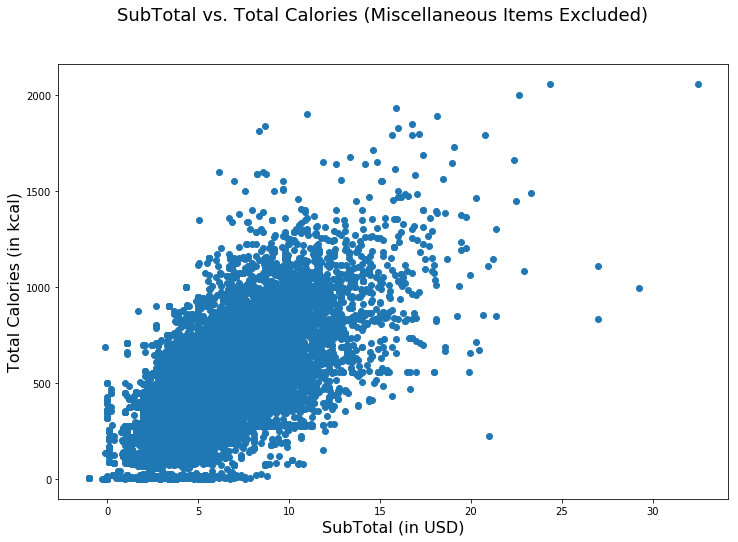

In [41]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal']>=0)]['SubTotal_wo_Misc'].reshape(-1, 1),
            aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal']>=0)]['Cal_wo_Misc'])
fig.suptitle('SubTotal vs. Total Calories (Miscellaneous Items Excluded)', fontsize=18)
plt.xlabel('SubTotal (in USD)', fontsize=16)
plt.ylabel('Total Calories (in kcal)', fontsize=16)
plt.show()

/Users/lingdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


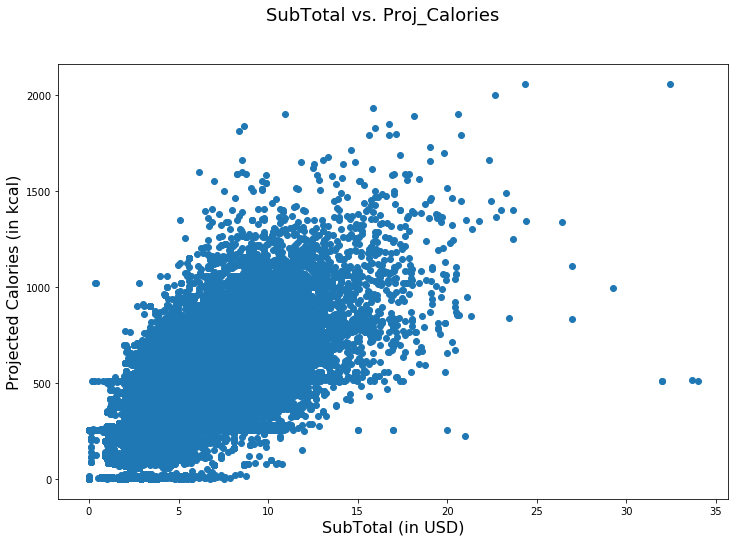

In [106]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal']>=0)]['SubTotal'].reshape(-1, 1),
            aggr_df[(aggr_df['#Items']<=5)&(aggr_df['SubTotal']>=0)]['TotalCalories'])
fig.suptitle('SubTotal vs. Proj_Calories', fontsize=18)
plt.xlabel('SubTotal (in USD)', fontsize=16)
plt.ylabel('Projected Calories (in kcal)', fontsize=16)
plt.show()

In [107]:
aggr_df.to_pickle('aggr_check_data.pkl')

## Label High/Low-Calorie Bottled Drinks

In [107]:
lookup_df.head()

,CafeName,#,Item #,Item Name,Calories,Calories.1,Scanner Item,Accuracy,Price,Category,Description,Comments
0,Gordon,275,100003,Misc,254.96,,,1,,,,
1,Harris,275,100003,Misc,254.96,,,1,,,,
2,Law,275,100003,Misc,254.96,,,1,,,,
3,Stuart,275,100003,Misc,254.96,,,1,,,,
4,Gordon,278,100058,SteamedMilkG,150.00,,,1,,,,


In [108]:
bottled_low_cal = list(lookup_df[(lookup_df['Category']=='Bottled Drink')&(lookup_df['Calories']<20)]['Item Name'].unique())
print(bottled_low_cal)

['Lipton Dt Green', 'SOBE LW ACAI RAS', 'SOBE LW BLd ORG', 'Aquafina Raspber', 'z DIET PEPSI 20', 'z DIET MT DEW 20', 'z AQUAFINA 20oz', 'z AQUAFINA  1LT', 'FLV SPLH WBRY 20', 'z LPT DT GRN CTR', 'z LPTN PureUnswt', 'z LPTN Nat DtGrT', 'z DIET COKE 20', 'z DIET COKE LM 2', 'z SPRITE ZERO 20', 'z Cke Cher Z 20', 'z COKE ZERO 20', 'z SNPLE DIET RAS', 'z SNPLE DIET PEA', 'z SNPLE DIET LEM', 'Smart Water', 'vitaminwater zer', 'z VIT water Foc', 'z Dr.PeppDiet 20', 'Snappe Diet H&H']


In [109]:
bottled_high_cal = list(lookup_df[(lookup_df['Category']=='Bottled Drink')&(lookup_df['Calories']>=20)]['Item Name'].unique())
print(bottled_high_cal)

['Fuze Iced Tea Md', 'Fuze Iced Tea Lg', 'Lipton Green Tea', 'Gatr Orange', 'Gatr Cool Blue', 'z TROP LEMONADE', 'z NJ STRW/BAN C', 'z NJ PRTN ZONE', 'z NJ POWER C', 'z NJ MITY MANGO', 'z NJ BERRY BLAST', 'z NJ ACAI MCHN', 'z NJ RED MACHINE', 'z NJ SFD GRN MAC', 'z NJ BLUE MCHN', 'SOBE BLK AND BLU', 'SOBE ENERGY 20oz', 'SOBE LW STRW KIW', 'SOBE LW Pac COCN', 'z GATR ORNG 20', 'z GATR FRPCH 20', 'GATR LEM LI 20oz', 'GATR FRST GL Fre', 'Lipton Half&Half', 'GATR GRP G2', 'Honest Tea Raspb', 'z PEPSI 20', 'z MT DEW 20', 'z STRBCKS FRPCOF', 'z STRBCKS FRPVAN', 'Pepsi WLDCher 20', 'z STRBCKS FRPMOC', 'LPTN ICED LEMON', 'DT SIERRA MIST 2', 'SIERRIA NATURAL', 'z LPTN  PURE LMN', 'z LPTN SWEET TEA', 'LPTN GN TE PS M', 'LPTN HON PEACH', 'z TRP NO PUL', 'z TRP CALCIU', 'z TRP SOME P', 'z TRP APPLE', 'z TRP CRANBE', 'z TRP GRAPE', 'z SPRITE 20', 'z CHERRY Peps 20', 'z VNLLA COKE 20', 'z COKE CLSSIC 20', 'z SNPLE PEACH TE', 'z SNPLE STR KIWI', 'z SNPLE MANGO MA', 'z SNPLE FRUIT PU', 'z SNPLE LEMO T

In [110]:
low_cal_vec = []
for item in db_item_names:
    if item in bottled_low_cal:
        low_cal_vec.append(1)
    else:
        low_cal_vec.append(0)
print(low_cal_vec)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

In [111]:
high_cal_vec = []
for item in db_item_names:
    if item in bottled_high_cal:
        high_cal_vec.append(1)
    else:
        high_cal_vec.append(0)
print(high_cal_vec)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 

In [112]:
def count_low_cal(item_vec, low_cal_vec):
    return np.dot(item_vec,np.array(low_cal_vec))

def count_high_cal(item_vec, high_cal_vec):
    return np.dot(item_vec,np.array(high_cal_vec))

aggr_df['#Low_Cal_Bottled_Drink'] = aggr_df['ItemVec'].apply(count_low_cal,low_cal_vec=low_cal_vec)
aggr_df['#High_Cal_Bottled_Drink'] = aggr_df['ItemVec'].apply(count_high_cal,high_cal_vec=high_cal_vec)

aggr_df[:1]

,Cashier,Check#,CreditCardInfo,Date,ItemVec,Open,PaymentMethod,PriceVec,QCFailed,Re,...,Coupon,TotalCalories,TimeClean,Hour,Cal_wo_Misc,SubTotal_wo_Misc,Proj_Calories,Proj_Cal_p_Dollar,#Low_Cal_Bottled_Drink,#High_Cal_Bottled_Drink
0,10017 ARA MGR,CHK383,VisaXXXXXXXXXXXX7463,DEC15'14,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,Credit Card,"[4.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,...,0.0,509.92,8:05,8,0.0,0.0,309.759081,69.142652,0,0


In [73]:
aggr_df[['cafe','Week','Week_of_Qtr','Day_of_Week', 'Treatment','SubTotal', 'TotalCalories',
         'Misc_Ind', 'SubTotal_wo_Misc', 'Cal_wo_Misc', 'TimeClean', 'Hour',
         'Proj_Calories','Proj_Cal_p_Dollar','#Items']].to_csv('chk-level-new.csv')

KeyError: "['Week' 'Week_of_Qtr' 'Day_of_Week' 'Treatment' 'TotalCalories' 'Misc_Ind'\n 'SubTotal_wo_Misc' 'Cal_wo_Misc' 'TimeClean' 'Hour' 'Proj_Calories'\n 'Proj_Cal_p_Dollar'] not in index"

# Data Analysis: Date-cafe-Level DataFrame (R preferred over Python)

In [121]:
daylvl_df = aggr_df[(aggr_df['#Items']<=5)&
                    (aggr_df['SubTotal']>0)].groupby(['DateClean', 'cafe'])[['SubTotal', '#Items','Proj_Calories','DateClean', 'cafe']].mean()

daylvl_count = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)].groupby(['DateClean', 'cafe'])['SubTotal'].count()

daylvl_bottled_lc = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)].groupby(['DateClean', 'cafe'])['#Low_Cal_Bottled_Drink'].sum()

daylvl_bottled_hc = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)].groupby(['DateClean', 'cafe'])['#High_Cal_Bottled_Drink'].sum()


daylvl_df['Count'] = daylvl_count
daylvl_df['Bottled_LC'] = daylvl_bottled_lc
daylvl_df['Bottled_HC'] = daylvl_bottled_hc
daylvl_df['LC%'] = daylvl_df['Bottled_LC']/(daylvl_df['Bottled_LC']+daylvl_df['Bottled_HC'])
daylvl_df['TotalSales'] = daylvl_df['SubTotal']*daylvl_df['Count']

daylvl_df.rename(index=str,columns={"#Items":'Items'},inplace=True)

daylvl_df[:1]

,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales
DateClean,cafe,,,,,,,,
2014-01-07,GCIS,4.568852,1.583732,325.206119,209,32,32,0.5,954.89


In [131]:
#For Table 8

daylvl_df = aggr_df[(aggr_df['#Items']<=5)&
                    (aggr_df['SubTotal']>0)&
                    (aggr_df['Misc_Ind']==0)].groupby(['DateClean', 'cafe'])[['SubTotal', '#Items','Proj_Calories','DateClean', 'cafe']].mean()

daylvl_count = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)&
                    (aggr_df['Misc_Ind']==0)].groupby(['DateClean', 'cafe'])['SubTotal'].count()

daylvl_bottled_lc = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)&
                    (aggr_df['Misc_Ind']==0)].groupby(['DateClean', 'cafe'])['#Low_Cal_Bottled_Drink'].sum()

daylvl_bottled_hc = aggr_df[(aggr_df['#Items']<=5)&
                       (aggr_df['SubTotal']>0)&
                    (aggr_df['Misc_Ind']==0)].groupby(['DateClean', 'cafe'])['#High_Cal_Bottled_Drink'].sum()


daylvl_df['Count'] = daylvl_count
daylvl_df['Bottled_LC'] = daylvl_bottled_lc
daylvl_df['Bottled_HC'] = daylvl_bottled_hc
daylvl_df['LC%'] = daylvl_df['Bottled_LC']/(daylvl_df['Bottled_LC']+daylvl_df['Bottled_HC'])
daylvl_df['TotalSales'] = daylvl_df['SubTotal']*daylvl_df['Count']

daylvl_df.rename(index=str,columns={"#Items":'Items'},inplace=True)

daylvl_df[:1]

,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales
DateClean,cafe,,,,,,,,
2014-01-07,GCIS,4.384076,1.516304,308.82663,184,30,28,0.517241,806.67


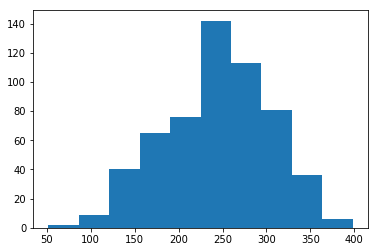

In [132]:
plt.hist(daylvl_df[daylvl_df['Count']>=10]['Proj_Calories'])
plt.show()

In [133]:
daylvl_df['DateClean'] = [t[0] for t in daylvl_df.axes[0].tolist()]
daylvl_df['cafe'] = [t[1] for t in daylvl_df.axes[0].tolist()]
daylvl_df[:1]

,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales,DateClean,cafe
DateClean,cafe,,,,,,,,,,
2014-01-07,GCIS,4.384076,1.516304,308.82663,184,30,28,0.517241,806.67,2014-01-07,GCIS


In [134]:
import datetime

def day_of_week(date_str):
    l = date_str.split("-")
    year = int(l[0])
    month = int(l[1])
    date = int(l[2])
    return datetime.datetime(year, month, date).weekday()+1

daylvl_df['Day_of_Week'] = daylvl_df['DateClean'].apply(day_of_week)
daylvl_df[:1]

,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales,DateClean,cafe,Day_of_Week
DateClean,cafe,,,,,,,,,,,
2014-01-07,GCIS,4.384076,1.516304,308.82663,184,30,28,0.517241,806.67,2014-01-07,GCIS,2


In [135]:
#Without washout periods

daylvl_df['Week'] = daylvl_df['DateClean'].apply(week_of_quarter)
daylvl_df['Treatment'] = daylvl_df['cafe']+'_'+daylvl_df['Week']+'_'+daylvl_df['Day_of_Week'].astype(str)

def treatment(cafe_wk_str):
    Law = ['BL','S1','BL','BL','BL','BL','BL','BL','BL','BL']
    Harris = ['BL','S4','BL','S3','BL','S2','BL','BL','S1','BL']
    Stuart = ['BL','S3','BL','S1','BL','S4','BL','BL','S2','BL']
    GCIS = ['BL','S2','BL','S4','BL','S1','BL','BL','S3','BL']
    
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    if year == '2015':
        week_index = int(wk[-1])
        if cafe == 'Law':
            return Law[week_index]
        elif cafe == 'Harris':
            return Harris[week_index]
        elif cafe == 'Stuart':
            return Stuart[week_index]
        elif cafe == 'GCIS':
            return GCIS[week_index]
    elif year == '2014':
        if quarter == 'Winter':
            return 'BL2'
        else:
            return 'BL1'
        
def coupon(cafe_wk_str):
    coupon = 0
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    if year == '2015':
        week_index = int(wk[-1])
        if week_index == 6:
            if day_of_week in ['1','3','5']:
                coupon = 1
    return coupon

daylvl_df['Treatment'] = daylvl_df['Treatment'].apply(treatment)
daylvl_df['Coupon'] = (daylvl_df['cafe']+'_'+daylvl_df['Week']+'_'+daylvl_df['Day_of_Week'].astype(str)).apply(coupon)

In [125]:
#With washout periods

daylvl_df['Week'] = daylvl_df['DateClean'].apply(week_of_quarter)
daylvl_df['Treatment'] = daylvl_df['cafe']+'_'+daylvl_df['Week']+'_'+daylvl_df['Day_of_Week'].astype(str)

def treatment(cafe_wk_str):
    Law = ['BL','S1','S1W','BL','BL','BL','BL','BL','BL','BL']
    Harris = ['BL','S4','S4W','S3','S3W','S2','BL','S2W','S1','S1W']
    Stuart = ['BL','S3','S3W','S1','S1W','S4','BL','S4W','S2','S2W']
    GCIS = ['BL','S2','S2W','S4','S4W','S1','BL','S1W','S3','S3W']
    
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    if year == '2015':
        week_index = int(wk[-1])
        if cafe == 'Law':
            return Law[week_index]
        elif cafe == 'Harris':
            return Harris[week_index]
        elif cafe == 'Stuart':
            return Stuart[week_index]
        elif cafe == 'GCIS':
            return GCIS[week_index]
    elif year == '2014':
        if quarter == 'Winter':
            return 'BL2'
        else:
            return 'BL1'
        
def coupon(cafe_wk_str):
    coupon = 0
    cafe = cafe_wk_str.split("_")[0]
    year = cafe_wk_str.split("_")[1]
    quarter = cafe_wk_str.split("_")[2]
    wk = cafe_wk_str.split("_")[3]
    day_of_week = cafe_wk_str.split("_")[4]
    if year == '2015':
        week_index = int(wk[-1])
        if week_index == 6:
            if day_of_week in ['1','3','5']:
                coupon = 1
    return coupon

daylvl_df['Treatment'] = daylvl_df['Treatment'].apply(treatment)
daylvl_df['Coupon'] = (daylvl_df['cafe']+'_'+daylvl_df['Week']+'_'+daylvl_df['Day_of_Week'].astype(str)).apply(coupon)

In [136]:
def w_of_q(week_str):
    if len(week_str.split("_"))==3:
        return str(week_str.split("_")[2][1:])
    else:
        return "2014"
    
daylvl_df['Week_of_Qtr'] = daylvl_df['Week'].apply(w_of_q)
daylvl_df[:1]

,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales,DateClean,cafe,Day_of_Week,Week,Treatment,Coupon,Week_of_Qtr
DateClean,cafe,,,,,,,,,,,,,,,
2014-01-07,GCIS,4.384076,1.516304,308.82663,184,30,28,0.517241,806.67,2014-01-07,GCIS,2,2014_Winter_W0,BL2,0,0


In [137]:
daylvl_df['Week_of_Qtr'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype=object)

In [138]:
print(daylvl_df['Day_of_Week'].unique())
for d in daylvl_df['Day_of_Week'].unique():
    daylvl_df[str(d)] = daylvl_df['Day_of_Week'].apply(lambda x: 1 if x == d else 0)
daylvl_df[:1]

[2 3 4 5 1]


,,SubTotal,Items,Proj_Calories,Count,Bottled_LC,Bottled_HC,LC%,TotalSales,DateClean,cafe,Day_of_Week,Week,Treatment,Coupon,Week_of_Qtr,2,3,4,5,1
DateClean,cafe,,,,,,,,,,,,,,,,,,,,
2014-01-07,GCIS,4.384076,1.516304,308.82663,184,30,28,0.517241,806.67,2014-01-07,GCIS,2,2014_Winter_W0,BL2,0,0,1,0,0,0,0


In [139]:
daylvl_df['Cal_p_Dollar'] = daylvl_df['Proj_Calories']/daylvl_df['SubTotal'] 
daylvl_df[:1]
daylvl_df.to_csv("cafe-date-level.csv", sep=",")